# Car Sales


In [63]:
import polars as pl
import seaborn as sns
from matplotlib import pyplot as plt

sns.set_theme()
%matplotlib inline

In [81]:
df = pl.read_csv("data/raw/car_sales/data.csv")
print("raw shape: ", df.shape)
rename_map = {col: col.lower().replace(" ", "_") for col in df.columns}

df = df.rename(rename_map).with_row_count("id")
df = (
    df.with_columns(
        [
            pl.col(col).str.replace_all(" ", "_").str.to_lowercase()
            for col in df.columns
            if df[col].dtype == pl.Utf8
        ]
    )
    .with_columns(
        pl.col(
            "make",
            "model",
            "engine_fuel_type",
            "transmission_type",
            "driven_wheels",
            "vehicle_size",
            "vehicle_style",
        ).cast(pl.Categorical),
    )
    .with_columns(
        pl.col("msrp").log10().alias("log_msrp"),
    )
)
df.head()

raw shape:  (11914, 16)


id,make,model,year,engine_fuel_type,engine_hp,engine_cylinders,transmission_type,driven_wheels,number_of_doors,market_category,vehicle_size,vehicle_style,highway_mpg,city_mpg,popularity,msrp,log_msrp
u32,cat,cat,i64,cat,i64,i64,cat,cat,i64,str,cat,cat,i64,i64,i64,i64,f64
0,"""bmw""","""1_series_m""",2011,"""premium_unlead…",335,6,"""manual""","""rear_wheel_dri…",2,"""factory_tuner,…","""compact""","""coupe""",26,19,3916,46135,4.664031
1,"""bmw""","""1_series""",2011,"""premium_unlead…",300,6,"""manual""","""rear_wheel_dri…",2,"""luxury,perform…","""compact""","""convertible""",28,19,3916,40650,4.609061
2,"""bmw""","""1_series""",2011,"""premium_unlead…",300,6,"""manual""","""rear_wheel_dri…",2,"""luxury,high-pe…","""compact""","""coupe""",28,20,3916,36350,4.560504
3,"""bmw""","""1_series""",2011,"""premium_unlead…",230,6,"""manual""","""rear_wheel_dri…",2,"""luxury,perform…","""compact""","""coupe""",28,18,3916,29450,4.469085
4,"""bmw""","""1_series""",2011,"""premium_unlead…",230,6,"""manual""","""rear_wheel_dri…",2,"""luxury""","""compact""","""convertible""",28,18,3916,34500,4.537819


In [109]:
df.describe().filter(pl.col("describe") == "null_count")

describe,id,make,model,year,engine_fuel_type,engine_hp,engine_cylinders,transmission_type,driven_wheels,number_of_doors,market_category,vehicle_size,vehicle_style,highway_mpg,city_mpg,popularity,msrp,log_msrp
str,f64,str,str,f64,str,f64,f64,str,str,f64,str,str,str,f64,f64,f64,f64,f64
"""null_count""",0.0,"""0""","""0""",0.0,"""0""",0.0,0.0,"""0""","""0""",0.0,"""0""","""0""","""0""",0.0,0.0,0.0,0.0,0.0


In [108]:
df = df.with_columns(
    pl.col("engine_cylinders").fill_null(0)
).drop_nulls(  # rotary and electric engines
    ["engine_fuel_type", "engine_hp", "number_of_doors"]
)  # missing values

In [74]:
df_market = (
    (
        df.select("id", "market_category")
        .with_columns([pl.col("market_category").str.split(",")])
        .explode("market_category")
    )
    .pivot(
        index="id",
        values="id",
        columns="market_category",
        aggregate_function="count",
    )
    .fill_null(0)
)
rename_map = {
    col: "market_" + col.lower().replace(" ", "_") if col != "id" else col
    for col in df_market.columns
}
df_market = df_market.rename(rename_map)
df = df.join(df_market, on="id")
df.head()

id,make,model,year,engine_fuel_type,engine_hp,engine_cylinders,transmission_type,driven_wheels,number_of_doors,market_category,vehicle_size,vehicle_style,highway_mpg,city_mpg,popularity,msrp,log_msrp,market_factory_tuner,market_luxury,market_high-performance,market_performance,market_flex_fuel,market_n/a,market_hatchback,market_hybrid,market_diesel,market_exotic,market_crossover
u32,cat,cat,i64,cat,i64,i64,cat,cat,i64,str,cat,cat,i64,i64,i64,i64,f64,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
0,"""bmw""","""1_series_m""",2011,"""premium_unlead…",335,6,"""manual""","""rear_wheel_dri…",2,"""factory_tuner,…","""compact""","""coupe""",26,19,3916,46135,4.664031,1,1,1,0,0,0,0,0,0,0,0
1,"""bmw""","""1_series""",2011,"""premium_unlead…",300,6,"""manual""","""rear_wheel_dri…",2,"""luxury,perform…","""compact""","""convertible""",28,19,3916,40650,4.609061,0,1,0,1,0,0,0,0,0,0,0
2,"""bmw""","""1_series""",2011,"""premium_unlead…",300,6,"""manual""","""rear_wheel_dri…",2,"""luxury,high-pe…","""compact""","""coupe""",28,20,3916,36350,4.560504,0,1,1,0,0,0,0,0,0,0,0
3,"""bmw""","""1_series""",2011,"""premium_unlead…",230,6,"""manual""","""rear_wheel_dri…",2,"""luxury,perform…","""compact""","""coupe""",28,18,3916,29450,4.469085,0,1,0,1,0,0,0,0,0,0,0
4,"""bmw""","""1_series""",2011,"""premium_unlead…",230,6,"""manual""","""rear_wheel_dri…",2,"""luxury""","""compact""","""convertible""",28,18,3916,34500,4.537819,0,1,0,0,0,0,0,0,0,0,0


[]

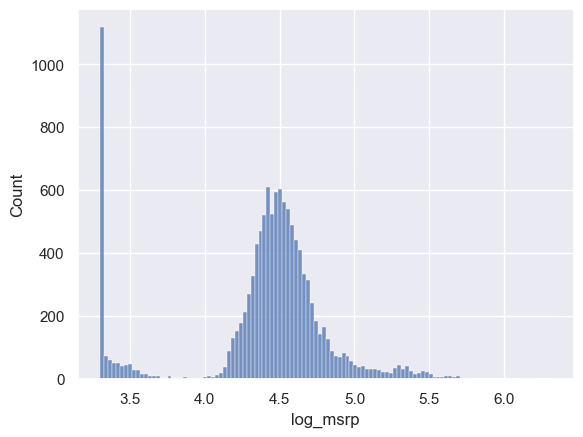

In [78]:
sns.histplot(df, x="log_msrp")
plt.plot()